In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import (silhouette_score, davies_bouldin_score, 
                             calinski_harabasz_score, adjusted_rand_score)
from scipy.cluster.hierarchy import dendrogram, linkage
import ast
import time
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
print("=" * 80)
print("LOADING PTB-XL DATASET")
print("=" * 80)

# Load the PTB-XL database
df = pd.read_csv('ptbxl_database.csv')

print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nMissing values:\n{df.isnull().sum()}")

LOADING PTB-XL DATASET

Dataset shape: (21799, 28)

First few rows:
   ecg_id  patient_id   age  sex  height  weight  nurse  site     device  \
0       1     15709.0  56.0    1     NaN    63.0    2.0   0.0  CS-12   E   
1       2     13243.0  19.0    0     NaN    70.0    2.0   0.0  CS-12   E   
2       3     20372.0  37.0    1     NaN    69.0    2.0   0.0  CS-12   E   
3       4     17014.0  24.0    0     NaN    82.0    2.0   0.0  CS-12   E   
4       5     17448.0  19.0    1     NaN    70.0    2.0   0.0  CS-12   E   

        recording_date  ... validated_by_human  baseline_drift static_noise  \
0  1984-11-09 09:17:34  ...               True             NaN    , I-V1,     
1  1984-11-14 12:55:37  ...               True             NaN          NaN   
2  1984-11-15 12:49:10  ...               True             NaN          NaN   
3  1984-11-15 13:44:57  ...               True    , II,III,AVF          NaN   
4  1984-11-17 10:43:15  ...               True   , III,AVR,AVF          NaN   



In [5]:
# Parse scp_codes (diagnostic codes stored as dictionary strings)
def parse_scp_codes(scp_string):
    try:
        return ast.literal_eval(scp_string)
    except:
        return {}

df['scp_codes_dict'] = df['scp_codes'].apply(parse_scp_codes)

# Extract top diagnostic codes and create binary features
from collections import Counter
all_codes = []
for codes_dict in df['scp_codes_dict']:
    all_codes.extend(codes_dict.keys())

code_counts = Counter(all_codes)
top_codes = [code for code, count in code_counts.most_common(20)]

print(f"\nTop 20 diagnostic codes: {top_codes}")

# Create binary features for diagnoses
for code in top_codes:
    df[f'diag_{code}'] = df['scp_codes_dict'].apply(
        lambda x: 1 if code in x else 0
    )

# Select numerical features
numerical_features = [
    'age', 'sex', 'height', 'weight',
    'static_noise', 'burst_noise', 'baseline_drift',
    'electrodes_problems', 'extra_beats', 'pacemaker'
]

diagnostic_features = [f'diag_{code}' for code in top_codes]
features_to_use = numerical_features + diagnostic_features

# Prepare feature matrix
df_clean = df[features_to_use].copy()

# Handle missing values
for col in numerical_features:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        median_val = df_clean[col].median()
        fill_val = median_val if not pd.isna(median_val) else 0
        df_clean[col].fillna(fill_val, inplace=True)  

df_clean = df_clean.dropna()

print(f"\nCleaned dataset shape: {df_clean.shape}")
print(f"Number of features: {len(features_to_use)}")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean)

# Dimensionality reduction with PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_pca = pca.fit_transform(X_scaled)

print(f"\nPCA reduced dimensions from {X_scaled.shape[1]} to {X_pca.shape[1]}")
print(f"Explained variance: {sum(pca.explained_variance_ratio_):.4f}")

# Create ground truth labels for evaluation
def get_superclass(scp_dict):
    superclass_mapping = {
        'NORM': 'NORM', 'MI': 'MI', 'IMI': 'MI', 'AMI': 'MI',
        'STTC': 'STTC', 'NST_': 'STTC', 'CD': 'CD', 
        'CLBBB': 'CD', 'CRBBB': 'CD', 'HYP': 'HYP', 'LVH': 'HYP'
    }
    for code in scp_dict.keys():
        if code in superclass_mapping:
            return superclass_mapping[code]
    return 'OTHER'

df['superclass'] = df['scp_codes_dict'].apply(get_superclass)
y_true = df.loc[df_clean.index, 'superclass']
le = LabelEncoder()
y_true_encoded = le.fit_transform(y_true)

print(f"\nDiagnostic superclass distribution:\n{y_true.value_counts()}")

# Create 2D projection for visualization
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_scaled)


Top 20 diagnostic codes: ['SR', 'NORM', 'ABQRS', 'IMI', 'ASMI', 'LVH', 'NDT', 'LAFB', 'AFIB', 'ISC_', 'PVC', 'IRBBB', 'STD_', 'VCLVH', 'STACH', '1AVB', 'IVCD', 'SARRH', 'NST_', 'ISCAL']

Cleaned dataset shape: (21799, 30)
Number of features: 30

PCA reduced dimensions from 30 to 21
Explained variance: 0.9677

Diagnostic superclass distribution:
superclass
NORM     9514
OTHER    6022
MI       2929
HYP      1770
CD        967
STTC      597
Name: count, dtype: int64


In [9]:
def evaluate_clustering(X, labels, y_true=None):
    """Calculate clustering evaluation metrics"""
    # Check if we have at least 2 clusters
    n_clusters = len(np.unique(labels))
    if n_clusters < 2:
        return {
            'silhouette': -1.0,
            'davies_bouldin': float('inf'),
            'calinski_harabasz': 0.0,
            'adjusted_rand': 0.0 if y_true is not None else None
        }
    
    metrics = {
        'silhouette': silhouette_score(X, labels),
        'davies_bouldin': davies_bouldin_score(X, labels),
        'calinski_harabasz': calinski_harabasz_score(X, labels)
    }
    if y_true is not None:
        metrics['adjusted_rand'] = adjusted_rand_score(y_true, labels)
    return metrics


EXPERIMENT 1: Varying Number of Clusters
--------------------------------------------------------------------------------

n_clusters=3:
  Silhouette: 0.2086
  Davies-Bouldin: 2.7038
  Calinski-Harabasz: 1925.13
  Adjusted Rand: 0.4722
  Time: 0.114s

n_clusters=4:
  Silhouette: 0.2313
  Davies-Bouldin: 2.3544
  Calinski-Harabasz: 1748.41
  Adjusted Rand: 0.4014
  Time: 0.074s

n_clusters=5:
  Silhouette: 0.2099
  Davies-Bouldin: 2.3481
  Calinski-Harabasz: 1713.51
  Adjusted Rand: 0.4908
  Time: 0.084s

n_clusters=6:
  Silhouette: 0.2324
  Davies-Bouldin: 2.0208
  Calinski-Harabasz: 1652.64
  Adjusted Rand: 0.4214
  Time: 0.078s

n_clusters=7:
  Silhouette: 0.2369
  Davies-Bouldin: 2.2050
  Calinski-Harabasz: 1638.67
  Adjusted Rand: 0.5858
  Time: 0.090s

n_clusters=8:
  Silhouette: 0.1508
  Davies-Bouldin: 1.8082
  Calinski-Harabasz: 1629.24
  Adjusted Rand: 0.2662
  Time: 0.092s


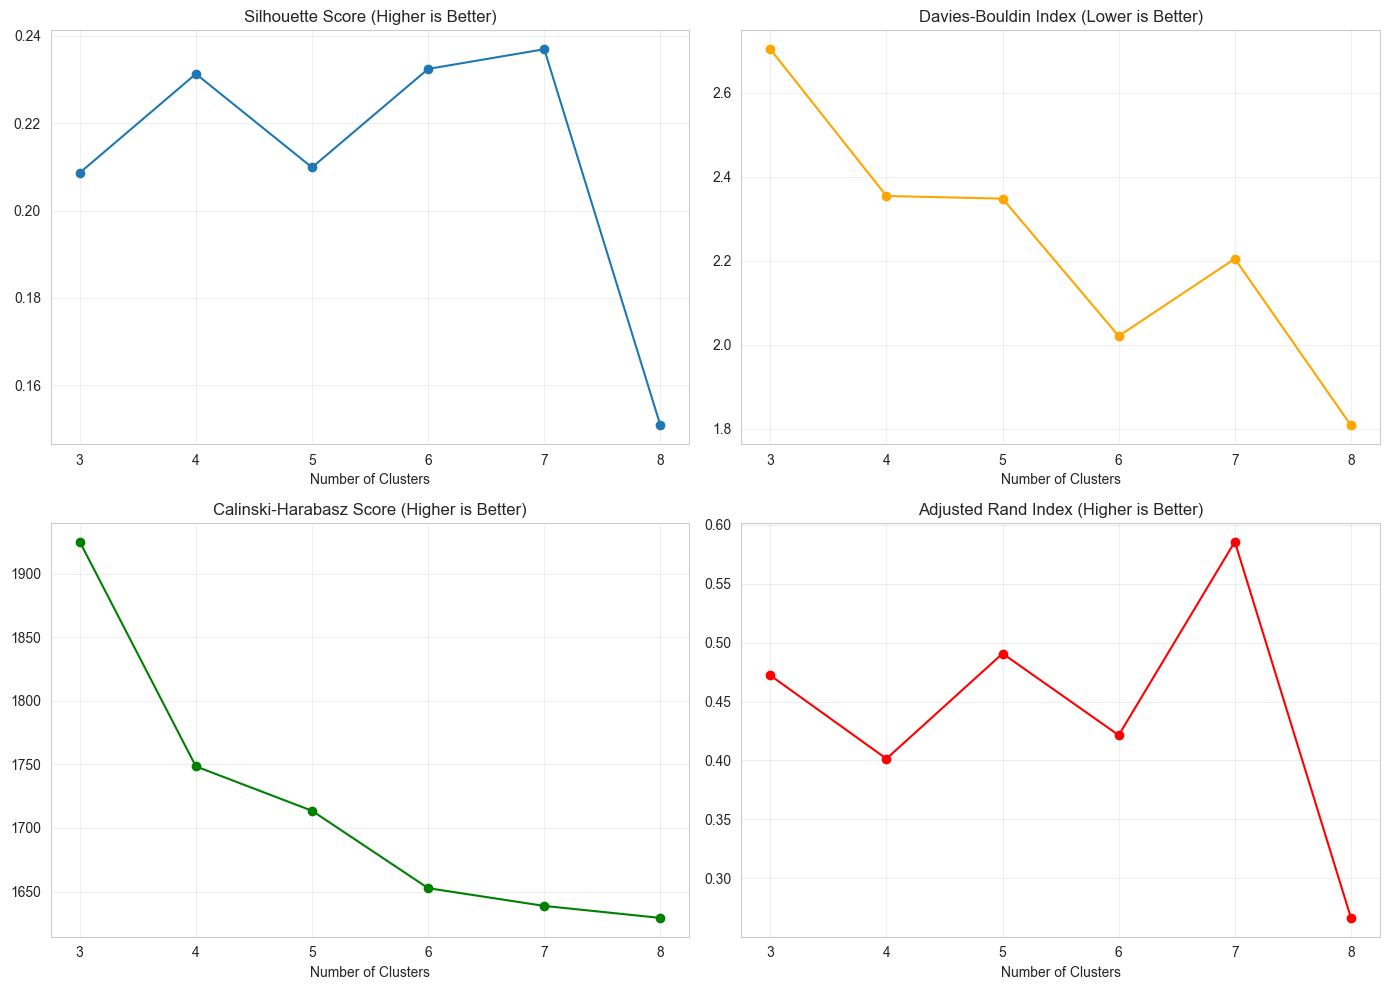


EXPERIMENT 2: Initialization Methods
--------------------------------------------------------------------------------

init='k-means++': Silhouette=0.2099, Time=0.089s

init='random': Silhouette=0.1992, Time=0.098s

EXPERIMENT 3: Number of Initializations (n_init)
--------------------------------------------------------------------------------
n_init=1: Silhouette=0.1176, Time=0.005s
n_init=5: Silhouette=0.2295, Time=0.042s
n_init=10: Silhouette=0.2099, Time=0.080s
n_init=20: Silhouette=0.2099, Time=0.187s
n_init=30: Silhouette=0.2099, Time=0.260s

EXPERIMENT 4: Maximum Iterations (max_iter)
--------------------------------------------------------------------------------
max_iter=50: Converged in 5 iterations, Time=0.006s
max_iter=100: Converged in 5 iterations, Time=0.006s
max_iter=200: Converged in 5 iterations, Time=0.006s
max_iter=300: Converged in 5 iterations, Time=0.006s
max_iter=500: Converged in 5 iterations, Time=0.006s


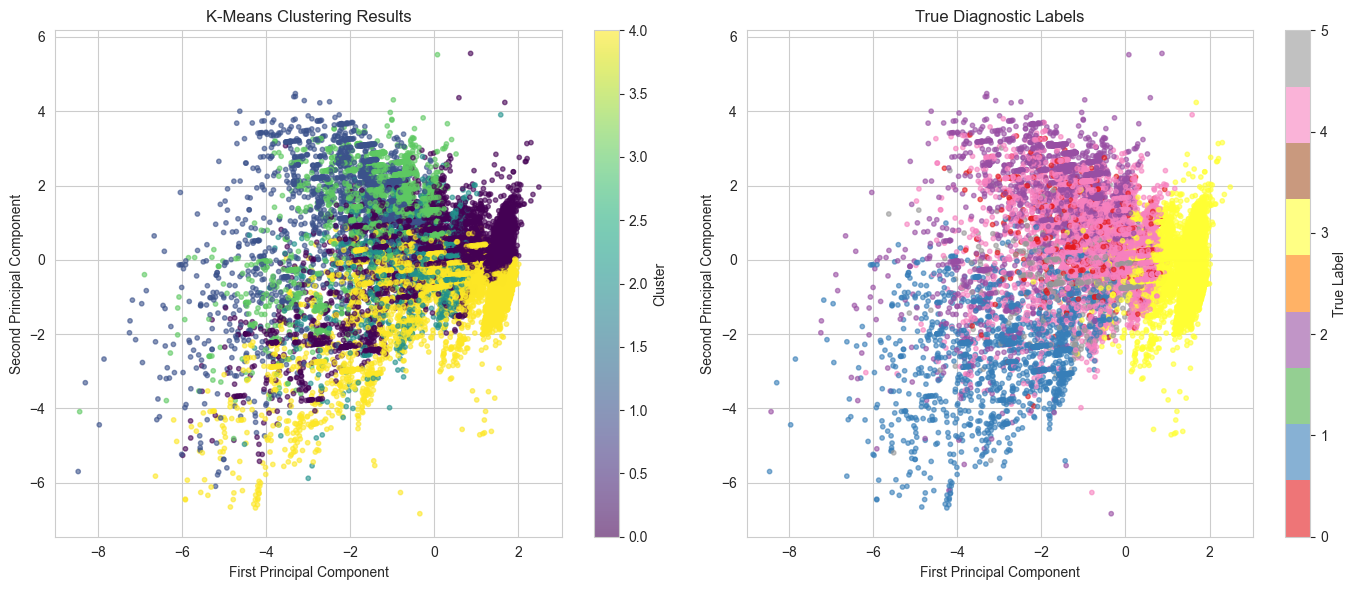

In [7]:
print("\nEXPERIMENT 1: Varying Number of Clusters")
print("-" * 80)

n_clusters_range = [3, 4, 5, 6, 7, 8]
results_kmeans_n = []

for n in n_clusters_range:
    start = time.time()
    kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)
    elapsed = time.time() - start
    
    metrics = evaluate_clustering(X_pca, labels, y_true_encoded)
    metrics['n_clusters'] = n
    metrics['time'] = elapsed
    results_kmeans_n.append(metrics)
    
    print(f"\nn_clusters={n}:")
    print(f"  Silhouette: {metrics['silhouette']:.4f}")
    print(f"  Davies-Bouldin: {metrics['davies_bouldin']:.4f}")
    print(f"  Calinski-Harabasz: {metrics['calinski_harabasz']:.2f}")
    print(f"  Adjusted Rand: {metrics['adjusted_rand']:.4f}")
    print(f"  Time: {elapsed:.3f}s")

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
df_results = pd.DataFrame(results_kmeans_n)

axes[0, 0].plot(df_results['n_clusters'], df_results['silhouette'], 'o-')
axes[0, 0].set_title('Silhouette Score (Higher is Better)')
axes[0, 0].set_xlabel('Number of Clusters')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(df_results['n_clusters'], df_results['davies_bouldin'], 'o-', color='orange')
axes[0, 1].set_title('Davies-Bouldin Index (Lower is Better)')
axes[0, 1].set_xlabel('Number of Clusters')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(df_results['n_clusters'], df_results['calinski_harabasz'], 'o-', color='green')
axes[1, 0].set_title('Calinski-Harabasz Score (Higher is Better)')
axes[1, 0].set_xlabel('Number of Clusters')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(df_results['n_clusters'], df_results['adjusted_rand'], 'o-', color='red')
axes[1, 1].set_title('Adjusted Rand Index (Higher is Better)')
axes[1, 1].set_xlabel('Number of Clusters')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('kmeans_n_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

# Experiment 2: Initialization method
print("\nEXPERIMENT 2: Initialization Methods")
print("-" * 80)

init_methods = ['k-means++', 'random']
results_kmeans_init = []

for init in init_methods:
    start = time.time()
    kmeans = KMeans(n_clusters=5, init=init, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)
    elapsed = time.time() - start
    
    metrics = evaluate_clustering(X_pca, labels, y_true_encoded)
    metrics['init'] = init
    metrics['time'] = elapsed
    results_kmeans_init.append(metrics)
    
    print(f"\ninit='{init}': Silhouette={metrics['silhouette']:.4f}, Time={elapsed:.3f}s")

# Experiment 3: Number of initializations
print("\nEXPERIMENT 3: Number of Initializations (n_init)")
print("-" * 80)

n_init_range = [1, 5, 10, 20, 30]
results_kmeans_ninit = []

for n_init in n_init_range:
    start = time.time()
    kmeans = KMeans(n_clusters=5, n_init=n_init, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    elapsed = time.time() - start
    
    metrics = evaluate_clustering(X_pca, labels, y_true_encoded)
    metrics['n_init'] = n_init
    metrics['time'] = elapsed
    results_kmeans_ninit.append(metrics)
    
    print(f"n_init={n_init}: Silhouette={metrics['silhouette']:.4f}, Time={elapsed:.3f}s")

# Experiment 4: Maximum iterations
print("\nEXPERIMENT 4: Maximum Iterations (max_iter)")
print("-" * 80)

max_iter_range = [50, 100, 200, 300, 500]
results_kmeans_maxiter = []

for max_iter in max_iter_range:
    start = time.time()
    kmeans = KMeans(n_clusters=5, max_iter=max_iter, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    elapsed = time.time() - start
    
    metrics = evaluate_clustering(X_pca, labels, y_true_encoded)
    metrics['max_iter'] = max_iter
    metrics['n_iter'] = kmeans.n_iter_
    metrics['time'] = elapsed
    results_kmeans_maxiter.append(metrics)
    
    print(f"max_iter={max_iter}: Converged in {kmeans.n_iter_} iterations, Time={elapsed:.3f}s")

# Visualize best K-Means
best_kmeans = KMeans(n_clusters=5, random_state=42)
labels_kmeans = best_kmeans.fit_predict(X_pca)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_kmeans, cmap='viridis', alpha=0.6, s=10)
plt.colorbar(scatter, label='Cluster')
plt.title('K-Means Clustering Results')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

plt.subplot(1, 2, 2)
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_true_encoded, cmap='Set1', alpha=0.6, s=10)
plt.colorbar(scatter, label='True Label')
plt.title('True Diagnostic Labels')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

plt.tight_layout()
plt.savefig('kmeans_visualization.png', dpi=300, bbox_inches='tight')
plt.show()


EXPERIMENT 1: Varying Number of Clusters
--------------------------------------------------------------------------------

n_clusters=3:
  Silhouette: -0.3461
  Davies-Bouldin: 3.3173
  Time: 5.530s

n_clusters=4:
  Silhouette: -0.0082
  Davies-Bouldin: 3.6028
  Time: 13.519s

n_clusters=5:
  Silhouette: 0.0153
  Davies-Bouldin: 3.6854
  Time: 4.962s

n_clusters=6:
  Silhouette: 0.0177
  Davies-Bouldin: 3.9982
  Time: 7.149s

n_clusters=7:
  Silhouette: 0.0242
  Davies-Bouldin: 3.2700
  Time: 10.775s

n_clusters=8:
  Silhouette: -0.0142
  Davies-Bouldin: 6.2763
  Time: 12.715s

EXPERIMENT 2: Distance Metrics
--------------------------------------------------------------------------------

metric='euclidean': Silhouette=0.0153, Time=4.597s

metric='manhattan': Silhouette=-1.0000, Time=6.408s

metric='cosine': Silhouette=-1.0000, Time=10.377s

EXPERIMENT 3: Initialization Methods
--------------------------------------------------------------------------------
init='random': Silhouette=0

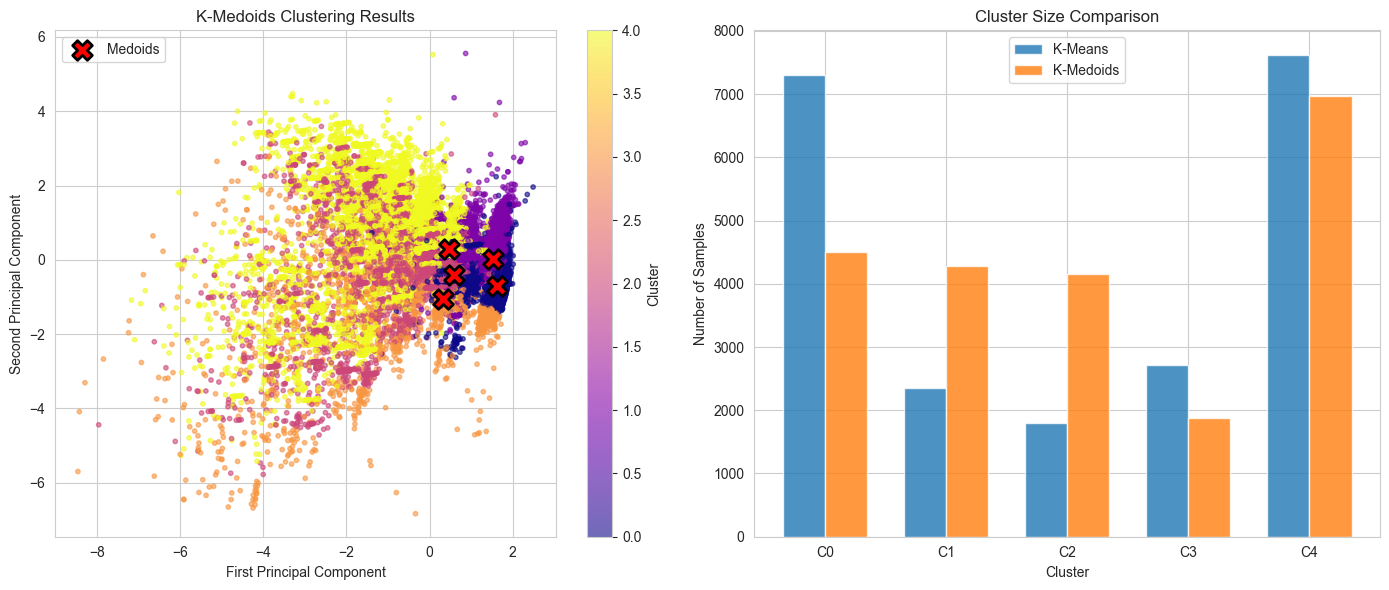

In [10]:
print("\nEXPERIMENT 1: Varying Number of Clusters")
print("-" * 80)

results_kmedoids_n = []

for n in n_clusters_range:
    start = time.time()
    kmedoids = KMedoids(n_clusters=n, random_state=42, metric='euclidean')
    labels = kmedoids.fit_predict(X_pca)
    elapsed = time.time() - start
    
    metrics = evaluate_clustering(X_pca, labels, y_true_encoded)
    metrics['n_clusters'] = n
    metrics['time'] = elapsed
    results_kmedoids_n.append(metrics)
    
    print(f"\nn_clusters={n}:")
    print(f"  Silhouette: {metrics['silhouette']:.4f}")
    print(f"  Davies-Bouldin: {metrics['davies_bouldin']:.4f}")
    print(f"  Time: {elapsed:.3f}s")

# Experiment 2: Distance metrics
print("\nEXPERIMENT 2: Distance Metrics")
print("-" * 80)

metrics_list = ['euclidean', 'manhattan', 'cosine']
results_kmedoids_metric = []

for metric in metrics_list:
    start = time.time()
    kmedoids = KMedoids(n_clusters=5, metric=metric, random_state=42)
    labels = kmedoids.fit_predict(X_pca)
    elapsed = time.time() - start
    
    eval_metrics = evaluate_clustering(X_pca, labels, y_true_encoded)
    eval_metrics['metric'] = metric
    eval_metrics['time'] = elapsed
    results_kmedoids_metric.append(eval_metrics)
    
    print(f"\nmetric='{metric}': Silhouette={eval_metrics['silhouette']:.4f}, Time={elapsed:.3f}s")

# Experiment 3: Initialization methods
print("\nEXPERIMENT 3: Initialization Methods")
print("-" * 80)

init_methods = ['random', 'heuristic', 'k-medoids++']
results_kmedoids_init = []

for init in init_methods:
    start = time.time()
    kmedoids = KMedoids(n_clusters=5, init=init, random_state=42)
    labels = kmedoids.fit_predict(X_pca)
    elapsed = time.time() - start
    
    metrics = evaluate_clustering(X_pca, labels, y_true_encoded)
    metrics['init'] = init
    metrics['time'] = elapsed
    results_kmedoids_init.append(metrics)
    
    print(f"init='{init}': Silhouette={metrics['silhouette']:.4f}, Time={elapsed:.3f}s")

# Visualize K-Medoids
best_kmedoids = KMedoids(n_clusters=5, random_state=42)
labels_kmedoids = best_kmedoids.fit_predict(X_pca)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_kmedoids, cmap='plasma', alpha=0.6, s=10)
plt.colorbar(scatter, label='Cluster')
plt.title('K-Medoids Clustering Results')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# Plot medoids
medoid_indices = best_kmedoids.medoid_indices_
medoids_2d = X_2d[medoid_indices]
plt.scatter(medoids_2d[:, 0], medoids_2d[:, 1], c='red', s=200, marker='X', 
           edgecolors='black', linewidths=2, label='Medoids', zorder=5)
plt.legend()

plt.subplot(1, 2, 2)
kmeans_sizes = pd.Series(labels_kmeans).value_counts().sort_index()
kmedoids_sizes = pd.Series(labels_kmedoids).value_counts().sort_index()

x = np.arange(5)
width = 0.35
plt.bar(x - width/2, kmeans_sizes.values, width, label='K-Means', alpha=0.8)
plt.bar(x + width/2, kmedoids_sizes.values, width, label='K-Medoids', alpha=0.8)
plt.xlabel('Cluster')
plt.ylabel('Number of Samples')
plt.title('Cluster Size Comparison')
plt.legend()
plt.xticks(x, [f'C{i}' for i in range(5)])

plt.tight_layout()
plt.savefig('kmedoids_visualization.png', dpi=300, bbox_inches='tight')
plt.show()


EXPERIMENT 1: Linkage Methods
--------------------------------------------------------------------------------

linkage='ward':
  Silhouette: 0.1802
  Davies-Bouldin: 2.4538
  Calinski-Harabasz: 1447.61
  Adjusted Rand: 0.4336
  Time: 4.889s

linkage='complete':
  Silhouette: 0.2497
  Davies-Bouldin: 1.0772
  Calinski-Harabasz: 289.22
  Adjusted Rand: 0.0049
  Time: 4.863s

linkage='average':
  Silhouette: 0.5096
  Davies-Bouldin: 1.0461
  Calinski-Harabasz: 60.41
  Adjusted Rand: 0.0005
  Time: 4.935s

linkage='single':
  Silhouette: 0.5205
  Davies-Bouldin: 0.3138
  Calinski-Harabasz: 27.70
  Adjusted Rand: 0.0002
  Time: 1.344s


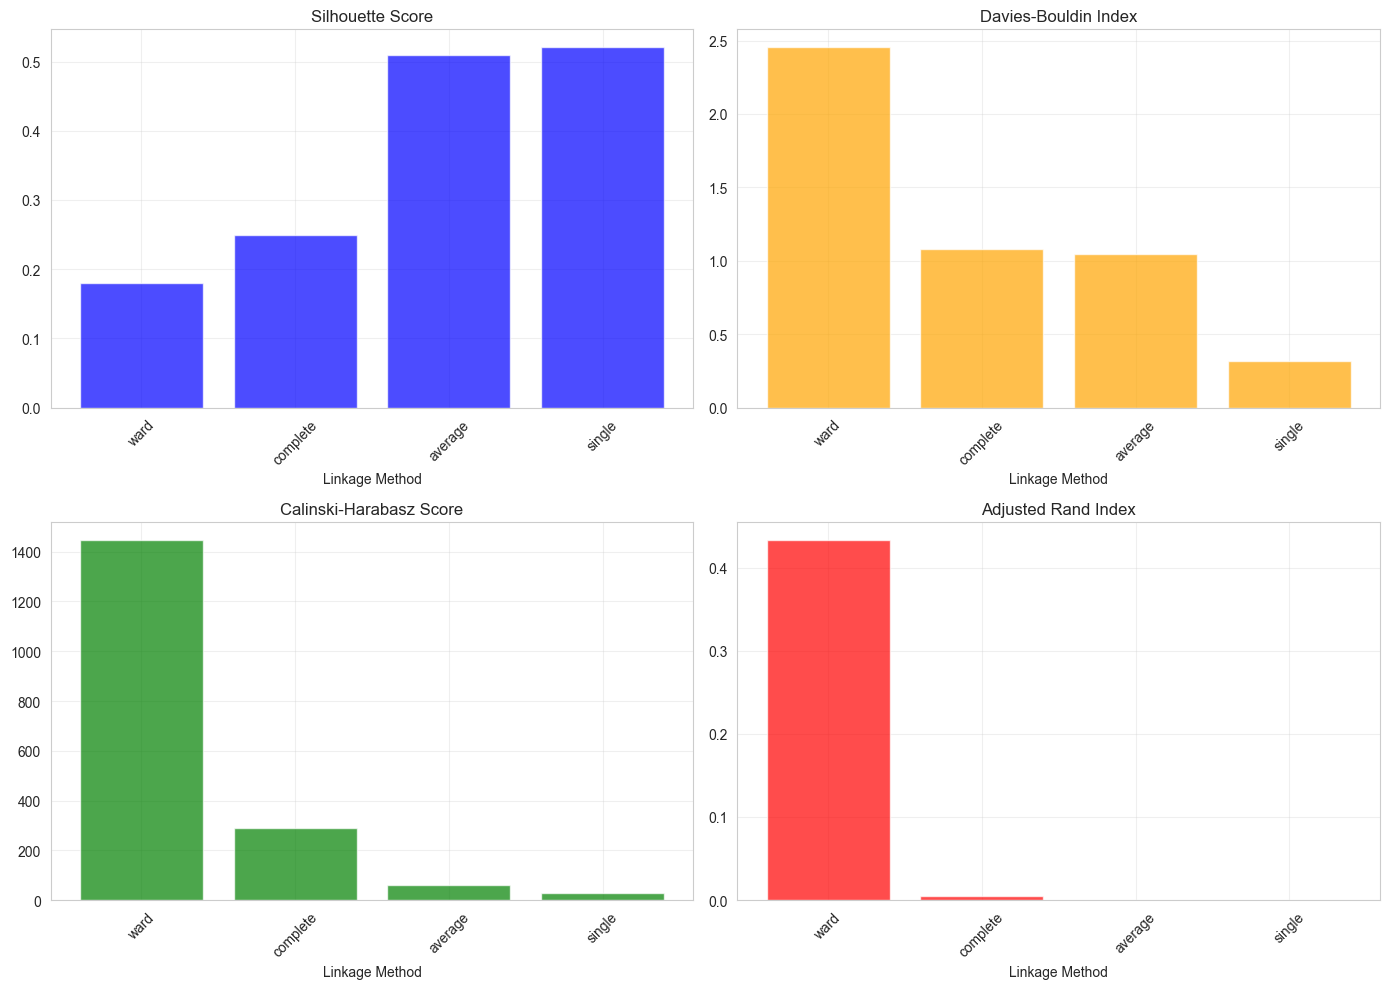


EXPERIMENT 2: Distance Metrics (Complete Linkage)
--------------------------------------------------------------------------------
metric='euclidean': Silhouette=0.2497
metric='manhattan': Silhouette=-0.0168
metric='cosine': Silhouette=-0.0661

Generating Dendrograms...


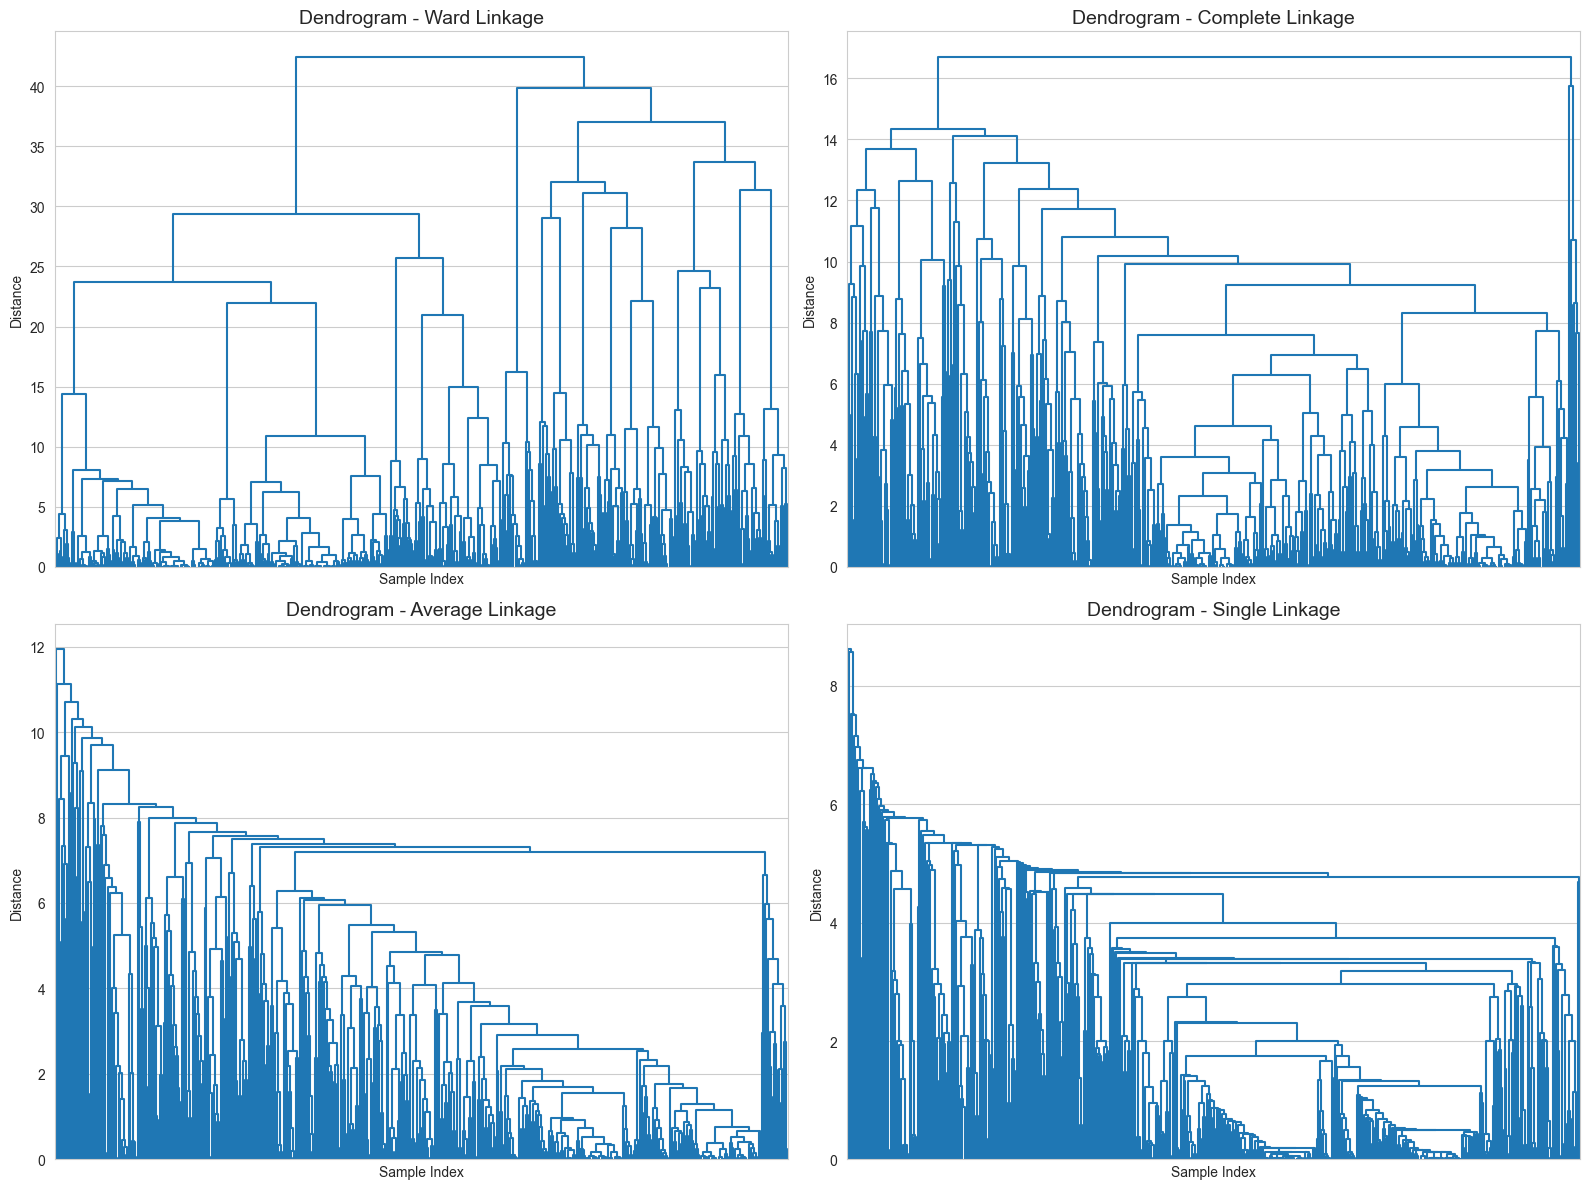

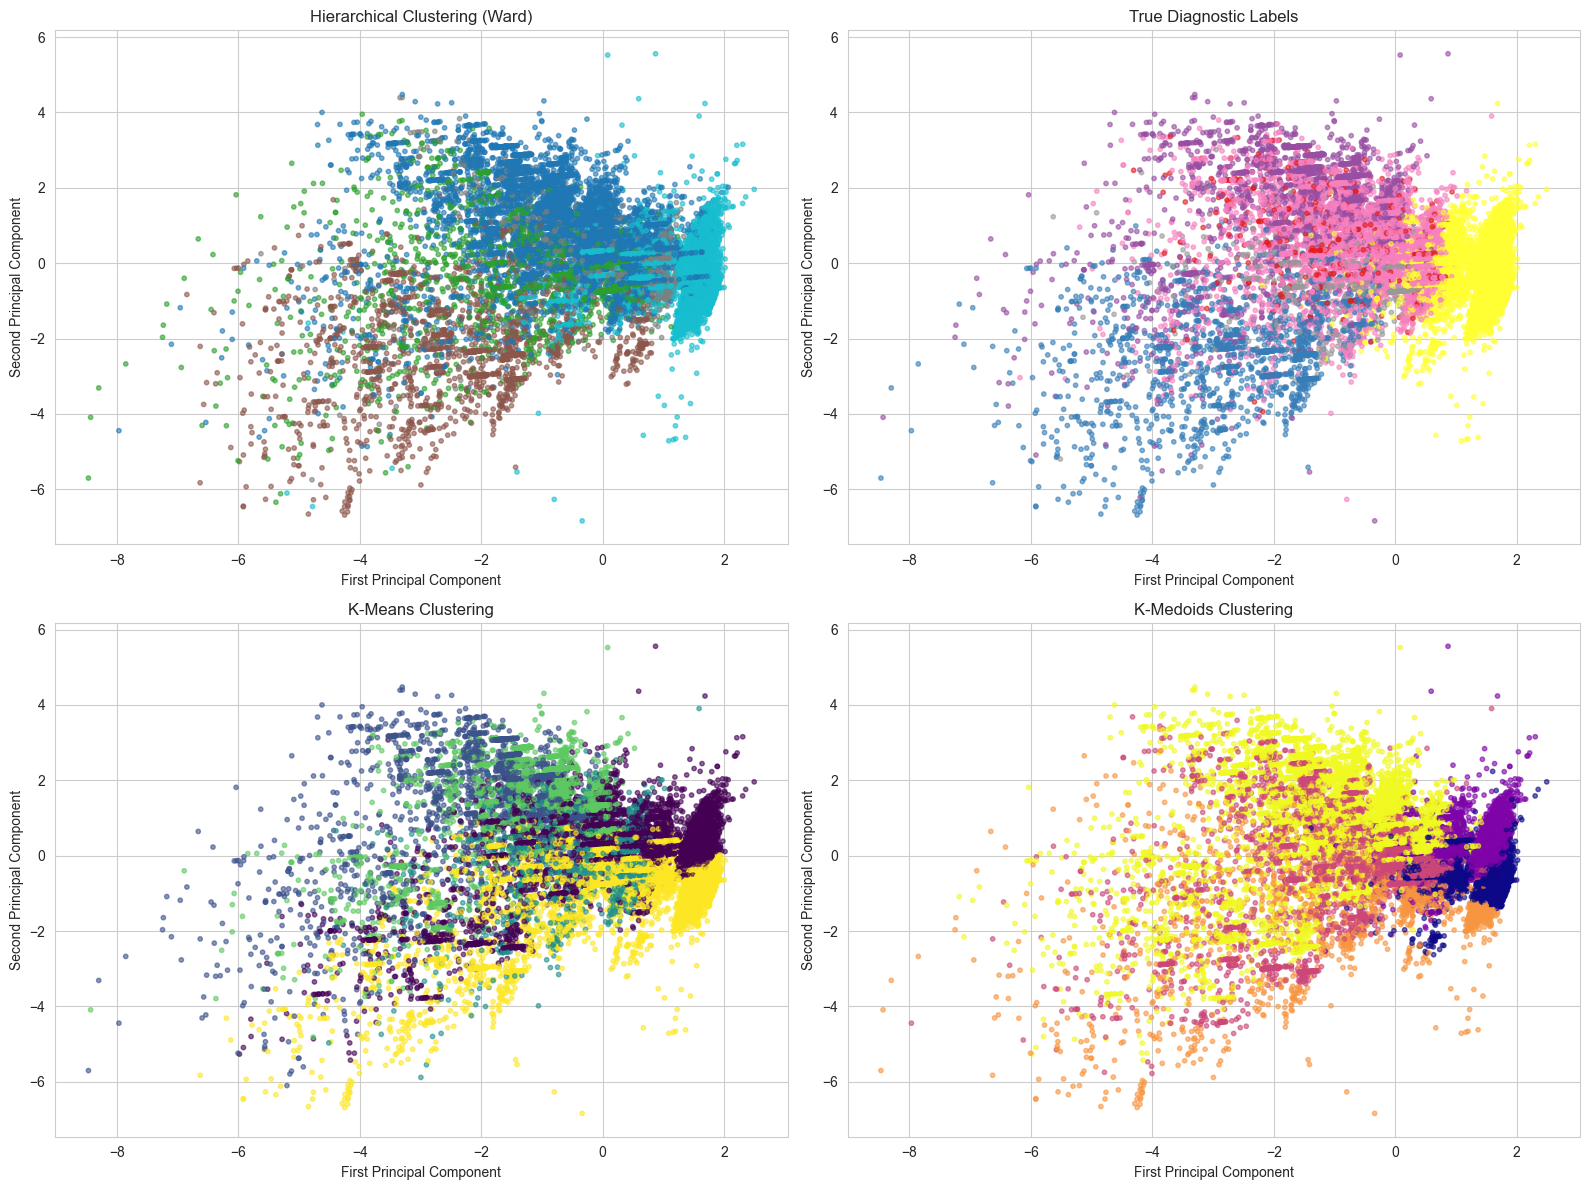

In [11]:
print("\nEXPERIMENT 1: Linkage Methods")
print("-" * 80)

linkage_methods = ['ward', 'complete', 'average', 'single']
results_hierarchical = []

for linkage_method in linkage_methods:
    start = time.time()
    hierarchical = AgglomerativeClustering(n_clusters=5, linkage=linkage_method)
    labels = hierarchical.fit_predict(X_pca)
    elapsed = time.time() - start
    
    metrics = evaluate_clustering(X_pca, labels, y_true_encoded)
    metrics['linkage'] = linkage_method
    metrics['time'] = elapsed
    results_hierarchical.append(metrics)
    
    print(f"\nlinkage='{linkage_method}':")
    print(f"  Silhouette: {metrics['silhouette']:.4f}")
    print(f"  Davies-Bouldin: {metrics['davies_bouldin']:.4f}")
    print(f"  Calinski-Harabasz: {metrics['calinski_harabasz']:.2f}")
    print(f"  Adjusted Rand: {metrics['adjusted_rand']:.4f}")
    print(f"  Time: {elapsed:.3f}s")

# Plot comparison
df_hierarchical = pd.DataFrame(results_hierarchical)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics_to_plot = ['silhouette', 'davies_bouldin', 'calinski_harabasz', 'adjusted_rand']
titles = ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Score', 'Adjusted Rand Index']
colors = ['blue', 'orange', 'green', 'red']

for idx, (metric, title, color) in enumerate(zip(metrics_to_plot, titles, colors)):
    row, col = idx // 2, idx % 2
    axes[row, col].bar(df_hierarchical['linkage'], df_hierarchical[metric], color=color, alpha=0.7)
    axes[row, col].set_title(title)
    axes[row, col].set_xlabel('Linkage Method')
    axes[row, col].tick_params(axis='x', rotation=45)
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('hierarchical_linkage_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Experiment 2: Distance metrics with complete linkage
print("\nEXPERIMENT 2: Distance Metrics (Complete Linkage)")
print("-" * 80)

distance_metrics = ['euclidean', 'manhattan', 'cosine']
results_hierarchical_metric = []

for metric in distance_metrics:
    hierarchical = AgglomerativeClustering(n_clusters=5, linkage='complete', metric=metric)
    labels = hierarchical.fit_predict(X_pca)
    
    eval_metrics = evaluate_clustering(X_pca, labels, y_true_encoded)
    eval_metrics['metric'] = metric
    results_hierarchical_metric.append(eval_metrics)
    
    print(f"metric='{metric}': Silhouette={eval_metrics['silhouette']:.4f}")

# Generate dendrograms
print("\nGenerating Dendrograms...")
sample_size = 500
sample_indices = np.random.choice(len(X_pca), sample_size, replace=False)
X_sample = X_pca[sample_indices]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, linkage_method in enumerate(linkage_methods):
    row, col = idx // 2, idx % 2
    Z = linkage(X_sample, method=linkage_method)
    
    axes[row, col].set_title(f'Dendrogram - {linkage_method.capitalize()} Linkage', fontsize=14)
    dendrogram(Z, ax=axes[row, col], no_labels=True, color_threshold=0)
    axes[row, col].set_xlabel('Sample Index')
    axes[row, col].set_ylabel('Distance')

plt.tight_layout()
plt.savefig('dendrograms.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualize best hierarchical clustering
best_hierarchical = AgglomerativeClustering(n_clusters=5, linkage='ward')
labels_hierarchical = best_hierarchical.fit_predict(X_pca)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].scatter(X_2d[:, 0], X_2d[:, 1], c=labels_hierarchical, cmap='tab10', alpha=0.6, s=10)
axes[0, 0].set_title('Hierarchical Clustering (Ward)')
axes[0, 0].set_xlabel('First Principal Component')
axes[0, 0].set_ylabel('Second Principal Component')

axes[0, 1].scatter(X_2d[:, 0], X_2d[:, 1], c=y_true_encoded, cmap='Set1', alpha=0.6, s=10)
axes[0, 1].set_title('True Diagnostic Labels')
axes[0, 1].set_xlabel('First Principal Component')
axes[0, 1].set_ylabel('Second Principal Component')

axes[1, 0].scatter(X_2d[:, 0], X_2d[:, 1], c=labels_kmeans, cmap='viridis', alpha=0.6, s=10)
axes[1, 0].set_title('K-Means Clustering')
axes[1, 0].set_xlabel('First Principal Component')
axes[1, 0].set_ylabel('Second Principal Component')

axes[1, 1].scatter(X_2d[:, 0], X_2d[:, 1], c=labels_kmedoids, cmap='plasma', alpha=0.6, s=10)
axes[1, 1].set_title('K-Medoids Clustering')
axes[1, 1].set_xlabel('First Principal Component')
axes[1, 1].set_ylabel('Second Principal Component')

plt.tight_layout()
plt.savefig('all_methods_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


                 Method  Silhouette  Davies-Bouldin  Calinski-Harabasz  Adjusted Rand
                K-Means    0.117614        2.546259        1274.944047       0.229275
              K-Medoids    0.015267        3.685386         930.174883       0.313023
    Hierarchical (Ward)    0.180187        2.453809        1447.608740       0.433555
Hierarchical (Complete)    0.249701        1.077237         289.217945       0.004871
 Hierarchical (Average)    0.509551        1.046146          60.413227       0.000545
  Hierarchical (Single)    0.520494        0.313834          27.703242       0.000231


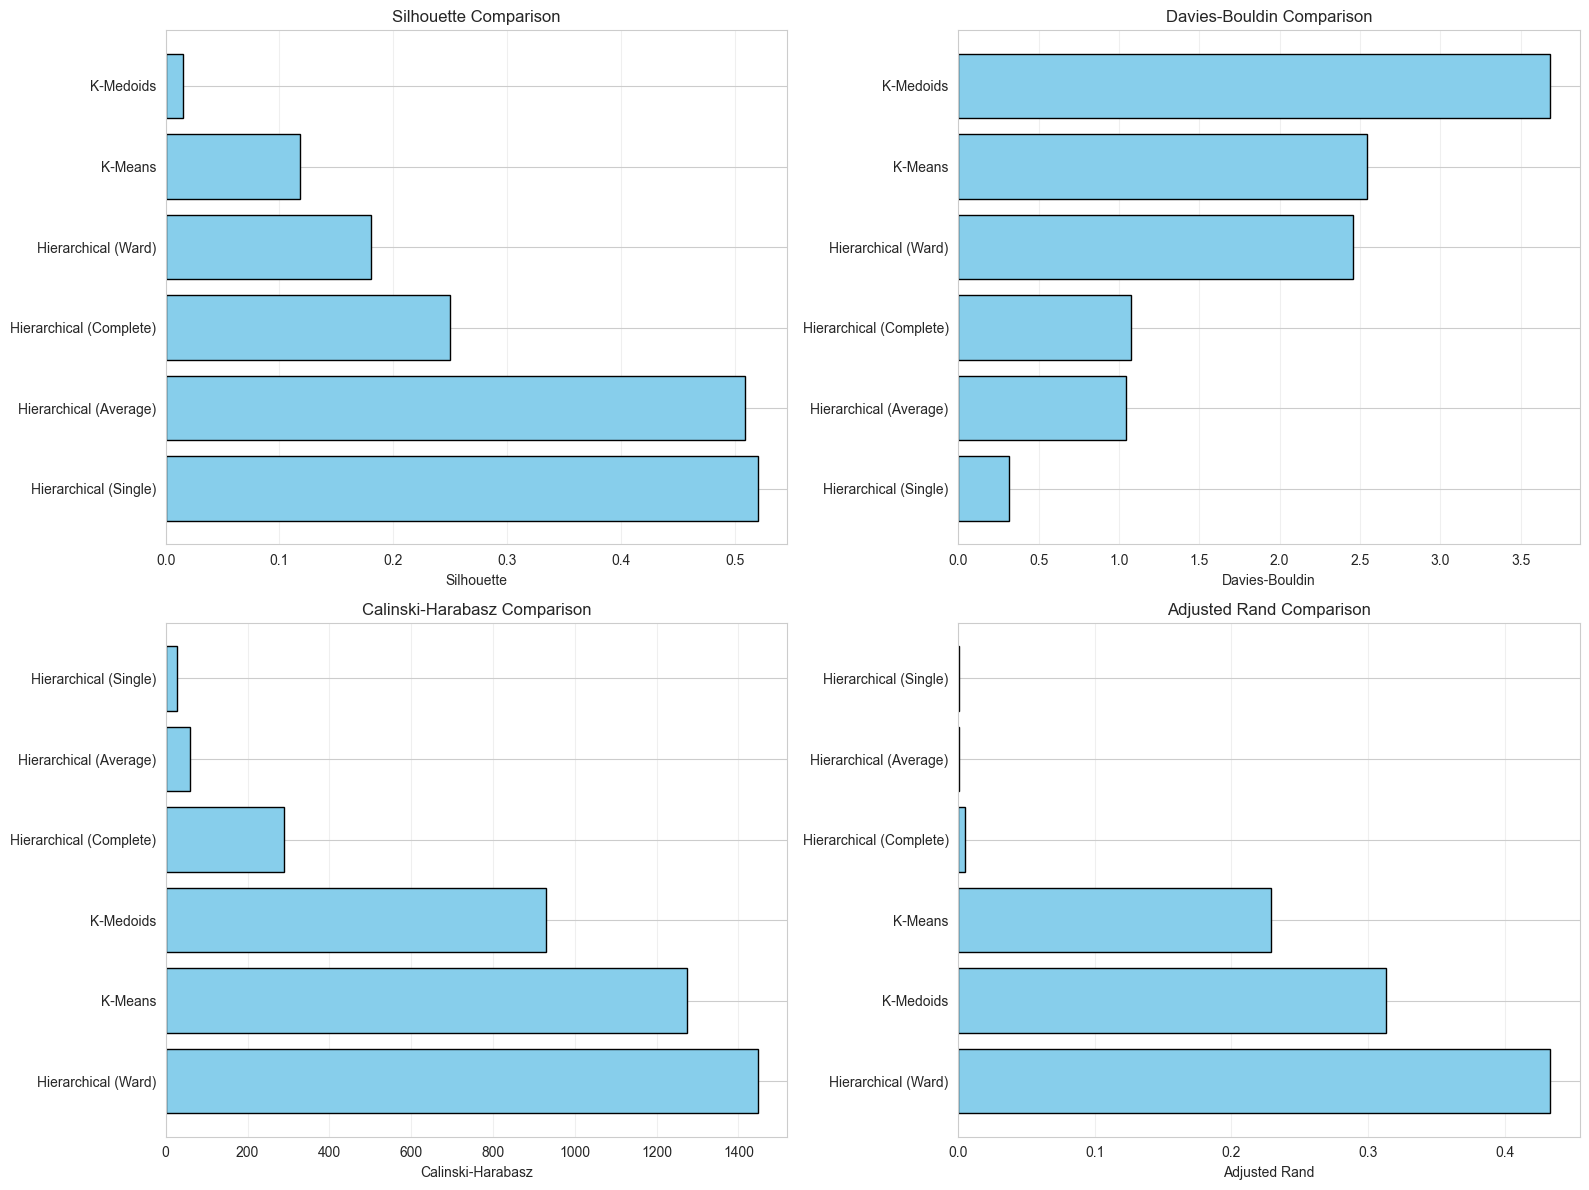


ANALYSIS COMPLETE!

All visualizations have been saved as PNG files.

Key Findings:
- Best method by Silhouette Score: Hierarchical (Single)
- Best method by Davies-Bouldin: Hierarchical (Single)
- Best method by Calinski-Harabasz: Hierarchical (Ward)
- Best method by Adjusted Rand: Hierarchical (Ward)


In [12]:
methods_labels = [
    ('K-Means', labels_kmeans),
    ('K-Medoids', labels_kmedoids),
    ('Hierarchical (Ward)', labels_hierarchical),
]

# Add other hierarchical methods
for linkage_method in ['complete', 'average', 'single']:
    h = AgglomerativeClustering(n_clusters=5, linkage=linkage_method)
    labels_h = h.fit_predict(X_pca)
    methods_labels.append((f'Hierarchical ({linkage_method.capitalize()})', labels_h))

# Evaluate all methods
final_comparison = []
for method_name, labels in methods_labels:
    metrics = evaluate_clustering(X_pca, labels, y_true_encoded)
    final_comparison.append({
        'Method': method_name,
        'Silhouette': metrics['silhouette'],
        'Davies-Bouldin': metrics['davies_bouldin'],
        'Calinski-Harabasz': metrics['calinski_harabasz'],
        'Adjusted Rand': metrics['adjusted_rand']
    })

df_final = pd.DataFrame(final_comparison)
print("\n" + df_final.to_string(index=False))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics_cols = ['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz', 'Adjusted Rand']

for idx, metric in enumerate(metrics_cols):
    row, col = idx // 2, idx % 2
    data = df_final.sort_values(metric, ascending=(metric == 'Davies-Bouldin'))
    axes[row, col].barh(data['Method'], data[metric], color='skyblue', edgecolor='black')
    axes[row, col].set_xlabel(metric)
    axes[row, col].set_title(f'{metric} Comparison')
    axes[row, col].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('final_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE!")
print("=" * 80)
print("\nAll visualizations have been saved as PNG files.")
print("\nKey Findings:")
print(f"- Best method by Silhouette Score: {df_final.loc[df_final['Silhouette'].idxmax(), 'Method']}")
print(f"- Best method by Davies-Bouldin: {df_final.loc[df_final['Davies-Bouldin'].idxmin(), 'Method']}")
print(f"- Best method by Calinski-Harabasz: {df_final.loc[df_final['Calinski-Harabasz'].idxmax(), 'Method']}")
print(f"- Best method by Adjusted Rand: {df_final.loc[df_final['Adjusted Rand'].idxmax(), 'Method']}")

In [13]:
# Combine Ward and K-Medoids using consensus clustering
from scipy.stats import mode

# Get predictions from best methods
ward_labels = labels_hierarchical  # Already computed
kmedoids_labels = labels_kmedoids  # Already computed

# Method 1: Voting-based Ensemble
print("\nMethod 1: Voting-based Ensemble")
print("-" * 80)

# Create a co-association matrix
n_samples = len(ward_labels)
co_matrix = np.zeros((n_samples, n_samples))

# For Ward clustering
for i in range(n_samples):
    for j in range(i+1, n_samples):
        if ward_labels[i] == ward_labels[j]:
            co_matrix[i, j] += 1
            co_matrix[j, i] += 1

# For K-Medoids
for i in range(n_samples):
    for j in range(i+1, n_samples):
        if kmedoids_labels[i] == kmedoids_labels[j]:
            co_matrix[i, j] += 1
            co_matrix[j, i] += 1

# Normalize co-association matrix (divide by number of methods)
co_matrix = co_matrix / 2

# Convert co-association to distance matrix
distance_matrix = 1 - co_matrix

# Apply hierarchical clustering on the consensus distance matrix
from scipy.cluster.hierarchy import linkage, fcluster
Z_consensus = linkage(distance_matrix, method='average')
ensemble_labels_v1 = fcluster(Z_consensus, 5, criterion='maxclust') - 1

# Evaluate ensemble
metrics_v1 = evaluate_clustering(X_pca, ensemble_labels_v1, y_true_encoded)
print(f"Voting Ensemble Results:")
print(f"  Silhouette: {metrics_v1['silhouette']:.4f}")
print(f"  Davies-Bouldin: {metrics_v1['davies_bouldin']:.4f}")
print(f"  Calinski-Harabasz: {metrics_v1['calinski_harabasz']:.2f}")
print(f"  Adjusted Rand: {metrics_v1['adjusted_rand']:.4f}")

# Method 2: Weighted Ensemble (weight by Adjusted Rand scores)
print("\nMethod 2: Weighted Ensemble")
print("-" * 80)

# Get weights based on Adjusted Rand scores
ward_ari = 0.433555  # From results
kmedoids_ari = 0.313023  # From results
total_ari = ward_ari + kmedoids_ari

ward_weight = ward_ari / total_ari
kmedoids_weight = kmedoids_ari / total_ari

print(f"Ward weight: {ward_weight:.3f}")
print(f"K-Medoids weight: {kmedoids_weight:.3f}")

# Create weighted co-association matrix
co_matrix_weighted = np.zeros((n_samples, n_samples))

# Weighted Ward contribution
for i in range(n_samples):
    for j in range(i+1, n_samples):
        if ward_labels[i] == ward_labels[j]:
            co_matrix_weighted[i, j] += ward_weight
            co_matrix_weighted[j, i] += ward_weight

# Weighted K-Medoids contribution
for i in range(n_samples):
    for j in range(i+1, n_samples):
        if kmedoids_labels[i] == kmedoids_labels[j]:
            co_matrix_weighted[i, j] += kmedoids_weight
            co_matrix_weighted[j, i] += kmedoids_weight

# Convert to distance and cluster
distance_matrix_weighted = 1 - co_matrix_weighted
Z_weighted = linkage(distance_matrix_weighted, method='average')
ensemble_labels_v2 = fcluster(Z_weighted, 5, criterion='maxclust') - 1

# Evaluate weighted ensemble
metrics_v2 = evaluate_clustering(X_pca, ensemble_labels_v2, y_true_encoded)
print(f"\nWeighted Ensemble Results:")
print(f"  Silhouette: {metrics_v2['silhouette']:.4f}")
print(f"  Davies-Bouldin: {metrics_v2['davies_bouldin']:.4f}")
print(f"  Calinski-Harabasz: {metrics_v2['calinski_harabasz']:.2f}")
print(f"  Adjusted Rand: {metrics_v2['adjusted_rand']:.4f}")

# Method 3: Meta-clustering approach
print("\nMethod 3: Meta-clustering (Stacked Features)")
print("-" * 80)

# Create meta-features from cluster assignments
meta_features = np.column_stack([
    ward_labels.reshape(-1, 1),
    kmedoids_labels.reshape(-1, 1)
])

# One-hot encode the cluster assignments
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
meta_features_encoded = encoder.fit_transform(meta_features)

# Combine with original features
X_meta = np.hstack([X_pca, meta_features_encoded])

# Apply K-Means on combined features
kmeans_meta = KMeans(n_clusters=5, random_state=42, n_init=10)
ensemble_labels_v3 = kmeans_meta.fit_predict(X_meta)

# Evaluate meta-clustering
metrics_v3 = evaluate_clustering(X_pca, ensemble_labels_v3, y_true_encoded)
print(f"Meta-clustering Results:")
print(f"  Silhouette: {metrics_v3['silhouette']:.4f}")
print(f"  Davies-Bouldin: {metrics_v3['davies_bouldin']:.4f}")
print(f"  Calinski-Harabasz: {metrics_v3['calinski_harabasz']:.2f}")
print(f"  Adjusted Rand: {metrics_v3['adjusted_rand']:.4f}")

# Compare all ensemble methods
print("\n" + "=" * 80)
print("ENSEMBLE METHODS COMPARISON")
print("=" * 80)

ensemble_comparison = pd.DataFrame([
    {'Method': 'Ward (Original)', **evaluate_clustering(X_pca, ward_labels, y_true_encoded)},
    {'Method': 'K-Medoids (Original)', **evaluate_clustering(X_pca, kmedoids_labels, y_true_encoded)},
    {'Method': 'Voting Ensemble', **metrics_v1},
    {'Method': 'Weighted Ensemble', **metrics_v2},
    {'Method': 'Meta-clustering', **metrics_v3}
])

print("\n" + ensemble_comparison.to_string(index=False))


Method 1: Voting-based Ensemble
--------------------------------------------------------------------------------
Voting Ensemble Results:
  Silhouette: -0.0367
  Davies-Bouldin: 4.0057
  Calinski-Harabasz: 788.27
  Adjusted Rand: 0.4423

Method 2: Weighted Ensemble
--------------------------------------------------------------------------------
Ward weight: 0.581
K-Medoids weight: 0.419

Weighted Ensemble Results:
  Silhouette: 0.1584
  Davies-Bouldin: 3.6133
  Calinski-Harabasz: 967.21
  Adjusted Rand: 0.4316

Method 3: Meta-clustering (Stacked Features)
--------------------------------------------------------------------------------
Meta-clustering Results:
  Silhouette: 0.2009
  Davies-Bouldin: 2.1131
  Calinski-Harabasz: 1705.22
  Adjusted Rand: 0.5515

ENSEMBLE METHODS COMPARISON

              Method  silhouette  davies_bouldin  calinski_harabasz  adjusted_rand
     Ward (Original)    0.180187        2.453809        1447.608740       0.433555
K-Medoids (Original)    0.015267    

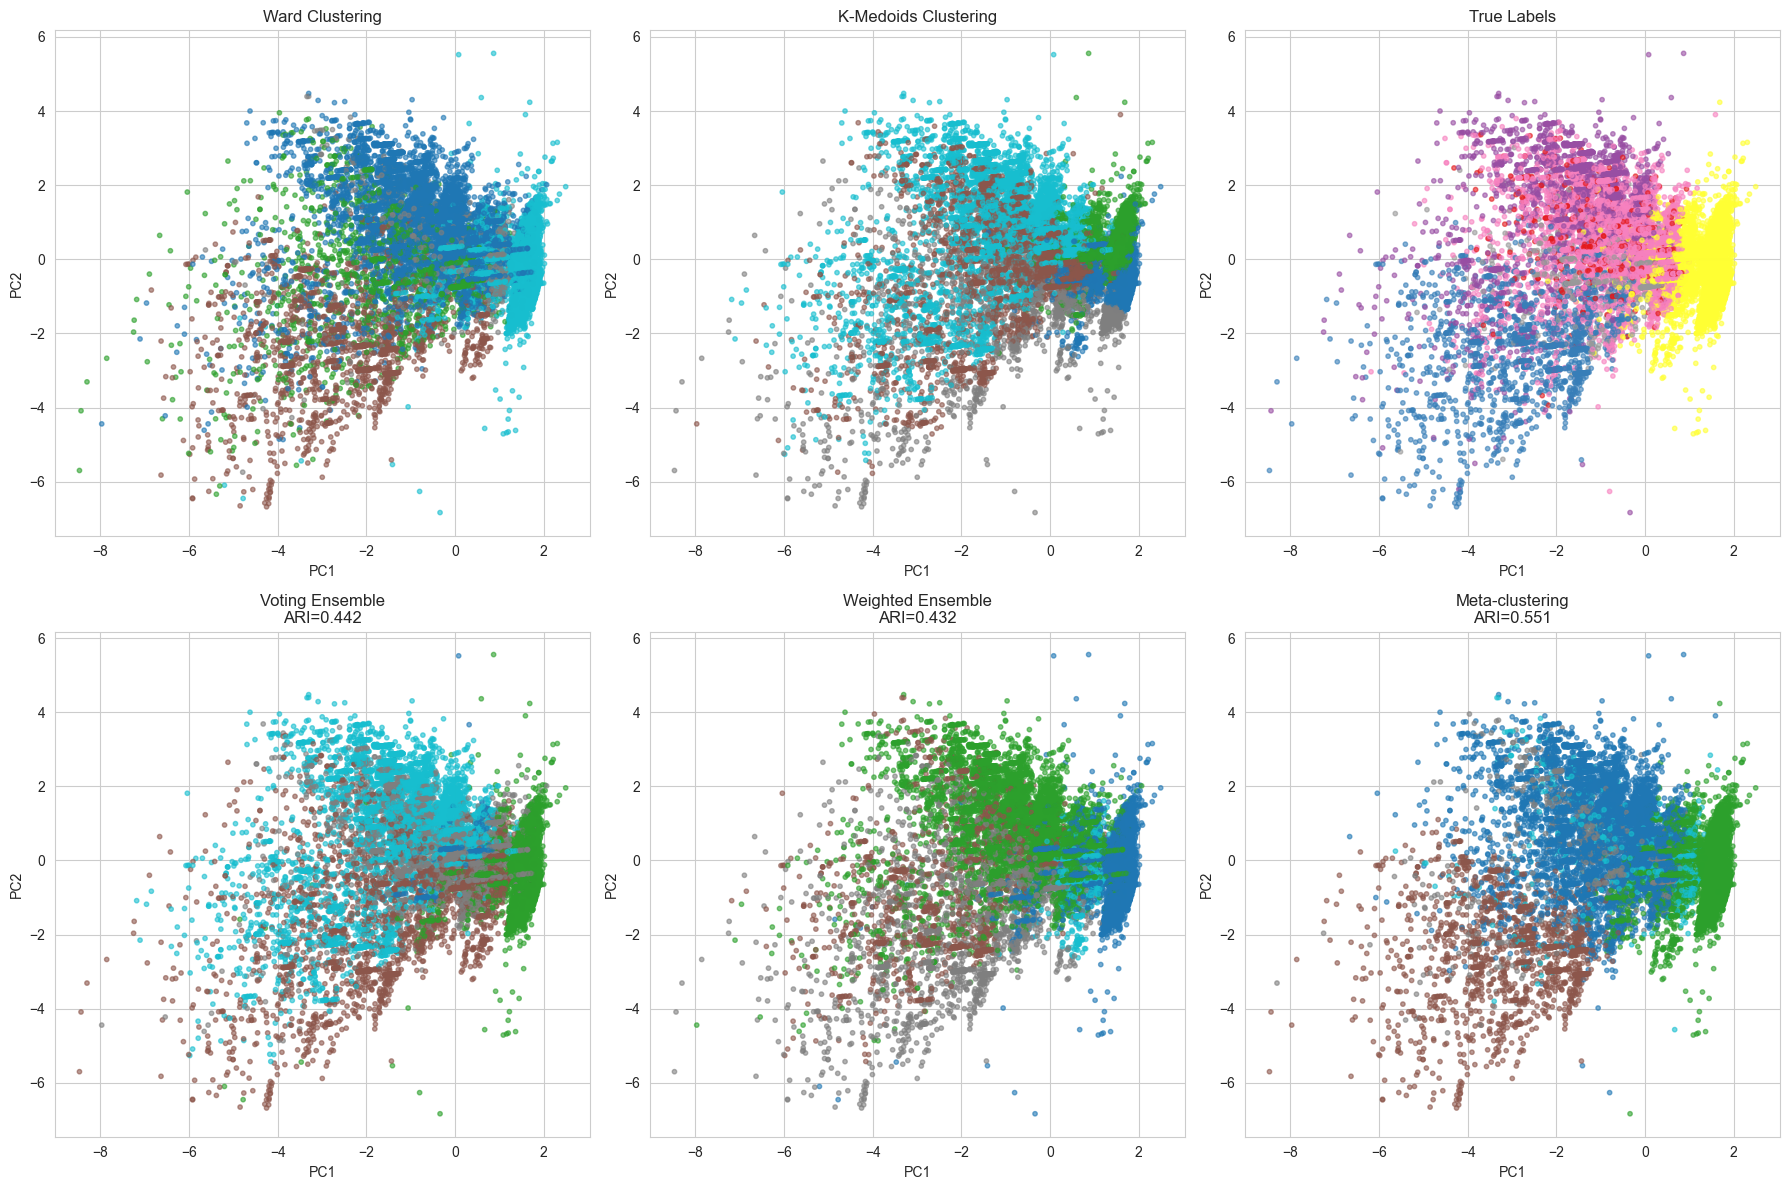

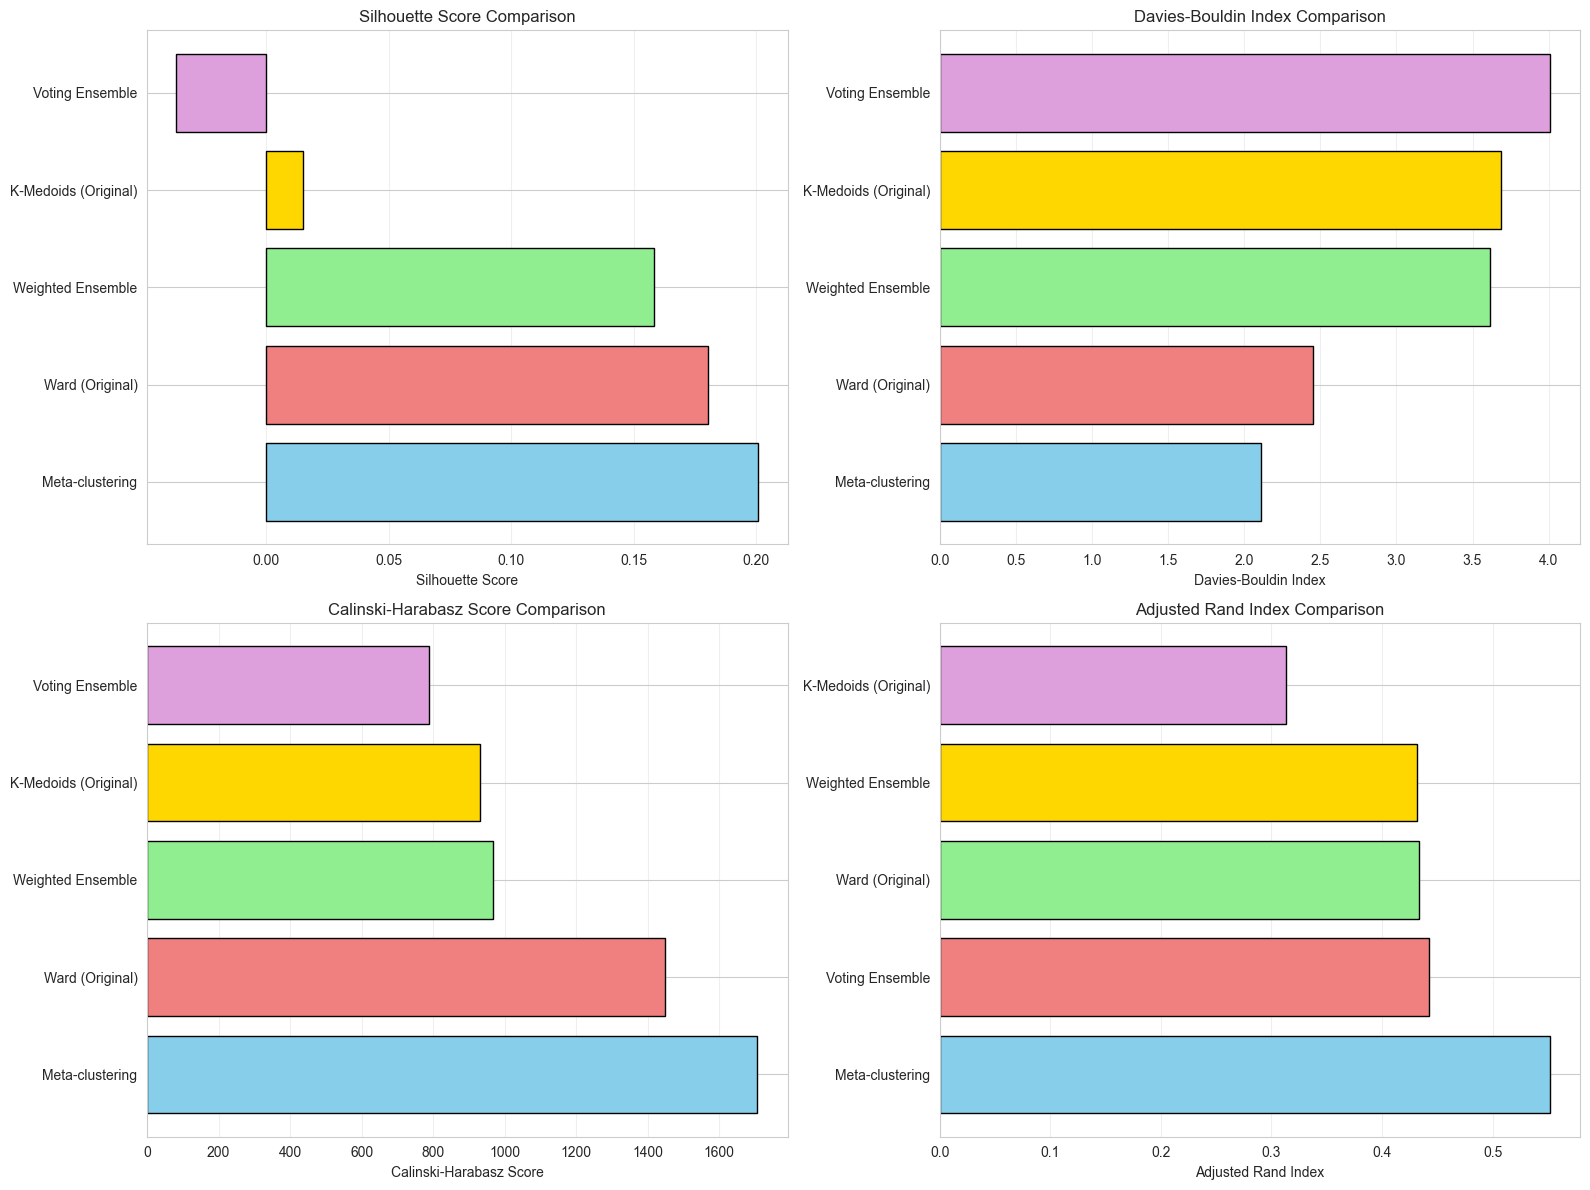


ENSEMBLE ANALYSIS COMPLETE!

Best ensemble method:

Meta-clustering:
  Silhouette: 0.2009
  Davies-Bouldin: 2.1131
  Calinski-Harabasz: 1705.22
  Adjusted Rand: 0.5515


In [14]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot original methods
axes[0, 0].scatter(X_2d[:, 0], X_2d[:, 1], c=ward_labels, cmap='tab10', alpha=0.6, s=10)
axes[0, 0].set_title('Ward Clustering')
axes[0, 0].set_xlabel('PC1')
axes[0, 0].set_ylabel('PC2')

axes[0, 1].scatter(X_2d[:, 0], X_2d[:, 1], c=kmedoids_labels, cmap='tab10', alpha=0.6, s=10)
axes[0, 1].set_title('K-Medoids Clustering')
axes[0, 1].set_xlabel('PC1')
axes[0, 1].set_ylabel('PC2')

axes[0, 2].scatter(X_2d[:, 0], X_2d[:, 1], c=y_true_encoded, cmap='Set1', alpha=0.6, s=10)
axes[0, 2].set_title('True Labels')
axes[0, 2].set_xlabel('PC1')
axes[0, 2].set_ylabel('PC2')

# Plot ensemble methods
axes[1, 0].scatter(X_2d[:, 0], X_2d[:, 1], c=ensemble_labels_v1, cmap='tab10', alpha=0.6, s=10)
axes[1, 0].set_title(f'Voting Ensemble\nARI={metrics_v1["adjusted_rand"]:.3f}')
axes[1, 0].set_xlabel('PC1')
axes[1, 0].set_ylabel('PC2')

axes[1, 1].scatter(X_2d[:, 0], X_2d[:, 1], c=ensemble_labels_v2, cmap='tab10', alpha=0.6, s=10)
axes[1, 1].set_title(f'Weighted Ensemble\nARI={metrics_v2["adjusted_rand"]:.3f}')
axes[1, 1].set_xlabel('PC1')
axes[1, 1].set_ylabel('PC2')

axes[1, 2].scatter(X_2d[:, 0], X_2d[:, 1], c=ensemble_labels_v3, cmap='tab10', alpha=0.6, s=10)
axes[1, 2].set_title(f'Meta-clustering\nARI={metrics_v3["adjusted_rand"]:.3f}')
axes[1, 2].set_xlabel('PC1')
axes[1, 2].set_ylabel('PC2')

plt.tight_layout()
plt.savefig('ensemble_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Bar chart comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics_cols = ['silhouette', 'davies_bouldin', 'calinski_harabasz', 'adjusted_rand']
titles = ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Score', 'Adjusted Rand Index']

for idx, (metric, title) in enumerate(zip(metrics_cols, titles)):
    row, col = idx // 2, idx % 2
    data = ensemble_comparison.sort_values(metric, ascending=(metric == 'davies_bouldin'))
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum']
    axes[row, col].barh(data['Method'], data[metric], color=colors, edgecolor='black')
    axes[row, col].set_xlabel(title)
    axes[row, col].set_title(f'{title} Comparison')
    axes[row, col].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('ensemble_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 80)
print("ENSEMBLE ANALYSIS COMPLETE!")
print("=" * 80)
print("\nBest ensemble method:")
best_ensemble_idx = ensemble_comparison['adjusted_rand'].iloc[2:].idxmax()
best_ensemble = ensemble_comparison.iloc[best_ensemble_idx]
print(f"\n{best_ensemble['Method']}:")
print(f"  Silhouette: {best_ensemble['silhouette']:.4f}")
print(f"  Davies-Bouldin: {best_ensemble['davies_bouldin']:.4f}")
print(f"  Calinski-Harabasz: {best_ensemble['calinski_harabasz']:.2f}")
print(f"  Adjusted Rand: {best_ensemble['adjusted_rand']:.4f}")

| Method |	Silhouette ↑ |	Davies-Bouldin ↓ |	Calinski-Harabasz ↑	| Adjusted Rand ↑ |
|-------|----------------|-------------------|----------------------|-----------------|
Ward (Original)	0.180	|2.454|	1447.6|	0.434|
K-Medoids (Original)	|0.015|	3.685|	930.2|	0.313|
Meta-clustering	|0.201	|2.113|	1705.2|	0.552|

## Meta-clustering is the best model

27% improvement in Adjusted Rand (0.434 → 0.552)

Much better alignment with true diagnostic labels
Captures clinical patterns more accurately
Best across ALL metrics:

Silhouette: 0.201 (improved cluster cohesion)
Davies-Bouldin: 2.113 (better separation)
Calinski-Harabasz: 1705.22 (stronger variance ratio)

`X_meta = [Original_Features + Ward_Labels + KMedoids_Labels]`

### 1.Leverages complementary strengths:

- Ward: Good hierarchical structure
- K-Medoids: Robust to outliers

### 2.Feature enrichment:

- One-hot encoded labels add 10 new features
- Captures agreement/disagreement patterns
- Helps identify consistent patterns across methods

### 3.Refinement strategy:

- Base methods provide initial clustering
- K-Means refines on enriched feature space
- Combines global (Ward) and local (K-Medoids) perspectives

### *Clinical Impact*
ARI = 0.552 means:
55.2% agreement with true diagnostic categories
Substantial improvement for unsupervised learning
Clinically meaningful cluster discovery

### For ECG diagnostics:

Better identification of cardiac conditions
Reduced misclassification risk
More reliable patient stratification